In [6]:
%load_ext autoreload
%autoreload 2

import cv2
import time
import torch
import numpy as np
from pprint import pprint
from PIL import Image, ImageDraw, ImageFont
from utils import display_images, refine_img_morphology, overlay_colored_masks
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def display_images(images: list, titles: list = None, grid: tuple = (1, None), figsize: tuple = (15, 5), show_axes: bool = True):
    """Отображает изображения с авто-генерацией технических заголовков."""
    if not images: return

    if titles is None:
        titles = []
        for i, img in enumerate(images):
            # Проверяем тип объекта: NumPy array или PIL Image
            if isinstance(img, np.ndarray):
                mode = 'N/A'
                if len(img.shape) == 2: mode = "L"
                elif img.shape[2] == 3: mode = 'RGB'
                elif img.shape[2] == 4: mode = 'RGBA'
                titles.append(f"img{i}, {img.shape}, {mode}")
            # Для PIL и подобных объектов с атрибутами size, mode
            elif hasattr(img, 'size'):
                titles.append(f"img{i}, {img.size}, {img.mode}, {getattr(img, 'format', None)}")
            else:
                titles.append(f"img{i}")

    num_images = len(images)
    rows, cols = grid
    if cols is None:
        cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.ravel(axes)

    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            if titles: ax.set_title(titles[i])
            if not show_axes: ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def cleanup(*objs, device="cuda:2", verbose=True):
    for obj in objs:
        del obj
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    d = device or torch.cuda.current_device()
    if verbose:
        alloc = torch.cuda.memory_allocated(d) / 1024**2
        reserved = torch.cuda.memory_reserved(d) / 1024**2
        print(f"[Cleanup] Dev{d} | Allocated: {alloc:.2f} MB | Reserved: {reserved:.2f} MB")

# Grounding DINO
- https://huggingface.co/IDEA-Research/grounding-dino-tiny
- https://huggingface.co/IDEA-Research/grounding-dino-base
- https://huggingface.co/google/owlv2-base-patch16-ensemble

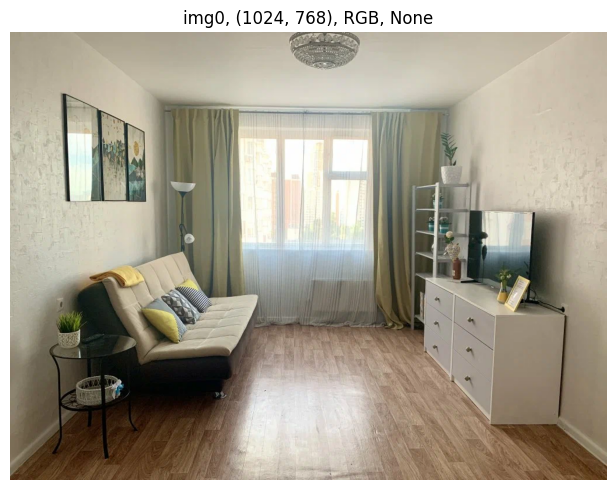

In [22]:
import torch
from PIL import Image, ImageDraw, ImageFont
import requests
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

device = "cuda:2"
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

img_pil = Image.open('data/img5004_BDorig.jpg').convert('RGB')
display_images([img_pil], show_axes=False)

/mnt/ssd/a-lugovoi/anaconda3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/mnt/ssd/a-lugovoi/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Пиковое потребление GPU памяти: 3262.95 MB
Время детекции: 0.1826 секунд


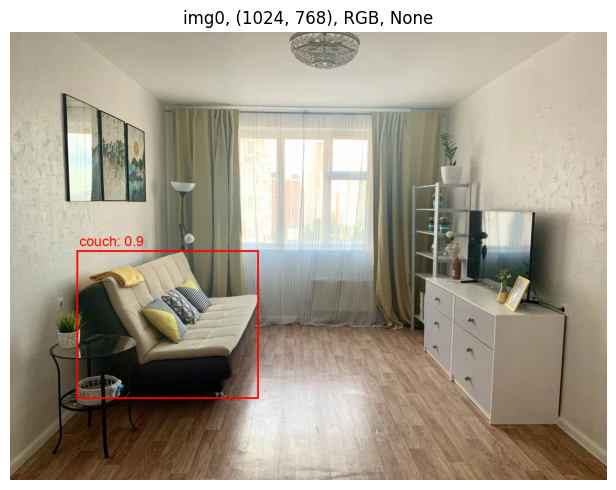

In [23]:
text = "couch."

# 4. Подготовка данных и перенос на GPU
inputs = processor(images=img_pil, text=text, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

torch.cuda.reset_peak_memory_stats(device) # Сбрасываем счетчик пиковой памяти
torch.cuda.synchronize() # Синхронизируемся для точного замера времени

start_time = time.time()

# 5. Инференс
with torch.no_grad():
    outputs = model(**inputs)

torch.cuda.synchronize()

end_time = time.time()
detection_time = end_time - start_time

# 6. Постобработка
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs["input_ids"],
    target_sizes=[img_pil.size[::-1]]
)

# 7. Рисование рамок
draw = ImageDraw.Draw(img_pil)
score_threshold = 0.3

font = ImageFont.truetype("data/arial.ttf", 24)
for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
    if score < score_threshold:
        continue
    
    box = [round(i, 2) for i in box.tolist()]
    draw.rectangle(box, outline="red", width=3)
    text_label = f"{label}: {round(score.item(), 2)}"
    text_position = (box[0] + 5, box[1] - 30)
    draw.text(text_position, text_label, fill="red", font=font)

peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2)
print(f"Пиковое потребление GPU памяти: {peak_memory_mb:.2f} MB")
print(f"Время детекции: {detection_time:.4f} секунд")

display_images([img_pil], show_axes=False)

# SAM
- https://github.com/facebookresearch/segment-anything
- https://github.com/IDEA-Research/Grounded-Segment-Anything
- https://huggingface.co/docs/transformers/model_doc/sam
- https://huggingface.co/facebook/sam-vit-huge

In [14]:
from transformers import SamModel, SamProcessor
import numpy as np


device = "cuda:2"

# Извлечение и фильтрация данных из результатов DINO
score_threshold = 0.3
res = results[0] # Результаты для первого (и единственного) изображения

# Создаем маску для фильтрации по порогу уверенности
keep = res["scores"] > score_threshold

# Фильтруем рамки, уверенность и метки
boxes = res["boxes"][keep]
scores = res["scores"][keep]
labels = [label for i, label in enumerate(res["labels"]) if keep[i]]

# Загрузка моделей SAM
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

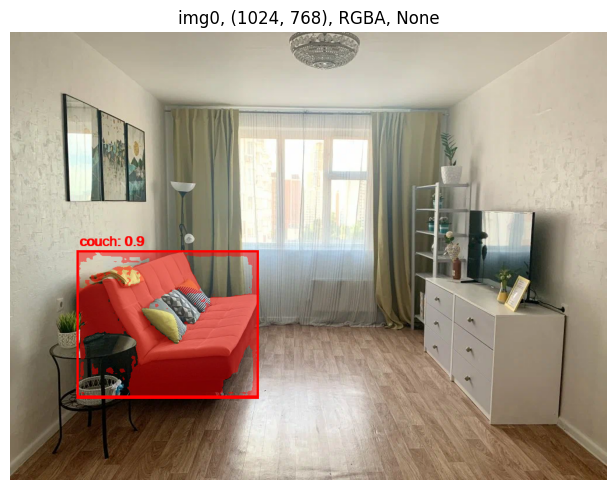

In [19]:
# Подготовка данных и получение масок
inputs = sam_processor(img_pil, input_boxes=[boxes.tolist()], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = sam_model(**inputs)
masks = sam_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]

# Берём лучшую маску по IOU
best_mask = masks[0, outputs.iou_scores[0].argmax()].numpy()  # (H, W) float

# Оба изображения в RGBA
base_img = img_pil.convert("RGBA")
overlay = Image.new("RGBA", base_img.size, (255, 0, 0, 0))  # прозрачный фон

# Маска -> альфа-канал
mask_alpha = (best_mask * 120).astype(np.uint8)  # 120 = прозрачность
r, g, b = 255, 0, 0
overlay_array = np.dstack([np.full_like(mask_alpha, r),
                           np.full_like(mask_alpha, g),
                           np.full_like(mask_alpha, b),
                           mask_alpha])

overlay = Image.fromarray(overlay_array, mode="RGBA")

# Полупрозрачное наложение
result = Image.alpha_composite(base_img, overlay)

display_images([result], show_axes=False)

# SAM

- https://github.com/facebookresearch/segment-anything
- https://github.com/IDEA-Research/Grounded-Segment-Anything
- https://huggingface.co/docs/transformers/model_doc/sam

In [2]:
# import pickle
# with open('bbox_info.pkl', 'rb') as f:
#     bbox_info = pickle.load(f)

In [29]:
bbox_info = res
bbox_info

{'scores': tensor([0.9038], device='cuda:2'),
 'boxes': tensor([[115.5296, 375.4927, 425.0862, 625.8414]], device='cuda:2'),
 'text_labels': ['couch'],
 'labels': ['couch']}

In [28]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model_id = "facebook/sam-vit-huge"
model = SamModel.from_pretrained(model_id).to(device)
processor = SamProcessor.from_pretrained(model_id)

boxes = bbox_info['boxes'].tolist()
inputs = processor(img_pil, input_boxes=[boxes], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu(), mask_threshold=-10
)
scores = outputs.iou_scores

numpy_data = masks[0].numpy().astype('uint8') * 255
image_data = numpy_data[0, 0]
maskl = Image.fromarray(image_data)

# Mask Postprocessing

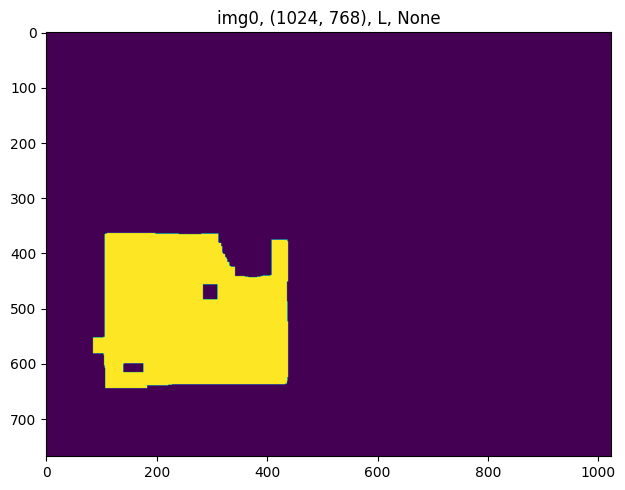

In [30]:
maskl = refine_img_morphology(maskl)
display_images([maskl])

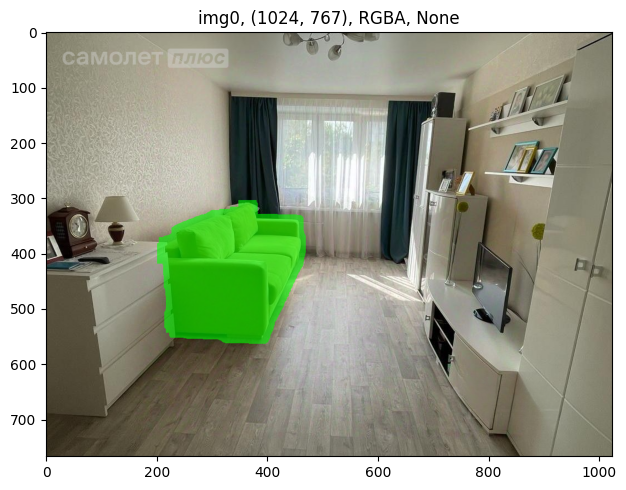

In [14]:
img_pil_colored = overlay_colored_masks(img_pil, [maskl])
display_images([img_pil_colored])

In [27]:
# img_pil_colored.convert('RGB').save('img006_img_pil_colored.jpg')

# Generation (Full Image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/108 [00:00<?, ?it/s]

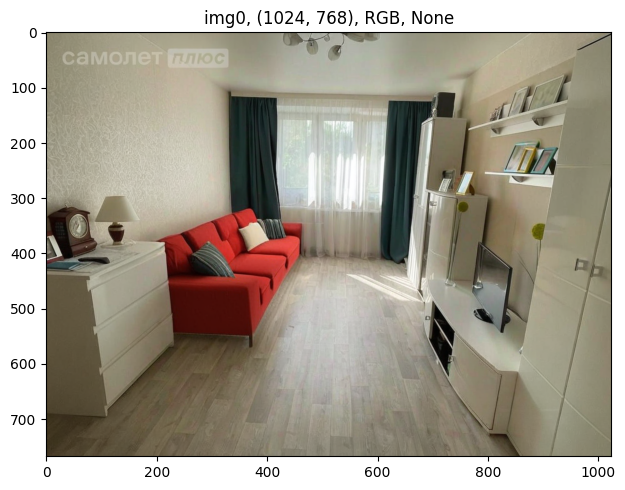

In [39]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

# nearest working size
def nearest_multiple(number, multiple=8, prefer_higher=None):
    lower_multiple = (number // multiple) * multiple
    higher_multiple = lower_multiple + multiple
    
    if prefer_higher is None:
        return lower_multiple if abs(number - lower_multiple) <= abs(number - higher_multiple) else higher_multiple
    return higher_multiple if prefer_higher else lower_multiple

height, width = nearest_multiple(img_pil.size[1]), nearest_multiple(img_pil.size[0])

# load pipe
model_id = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
pipe = AutoPipelineForInpainting.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16",
    cache_dir=CACHE_DIR
).to(DEVICE)

# inference
prompt = "red couch"
generator = torch.Generator(device=DEVICE).manual_seed(4)

img_generated_pil = pipe(
    prompt=prompt,
    image=img_pil,
    mask_image=mask_l,
    guidance_scale=8.0,
    num_inference_steps=120, 
    strength=0.9,
    height=height,
    width=width,
    generator=generator,
)

img_generated_pil = img_generated_pil.images[0]
display_images([img_generated_pil])

In [41]:
# img_generated_pil.save('img007_generated.jpg')

# Generation (Cropped mask)

In [6]:
def expand_crop_side(current_coords, original_size, target_length):
    start, end = current_coords
    current_length = end - start

    # Вычисление, сколько не хватает до желаемого размера
    delta = target_length - current_length
    if delta <= 0:
        return current_coords  # Текущий размер уже соответствует или превышает целевой

    # Рассчитываем расширение с каждой стороны
    expand_one_side = min(delta // 2, start)
    expand_other_side = min(delta - expand_one_side, original_size - end)

    # Расширяем обрезку
    new_start = start - expand_one_side
    new_end = end + expand_other_side

    # Компенсация, если одна сторона достигла границы
    remaining = delta - (expand_one_side + expand_other_side)
    new_start = max(new_start - remaining, 0) if new_end == original_size else new_start
    new_end = min(new_end + remaining, original_size) if new_start == 0 else new_end

    return (new_start, new_end)


def to_multiplicity_size(start_coord, end_coord, original_size, target_multiple=8):
    """
    делает кратность к target_multiple
    если доступно - расширяет в большую сторону
    если нет - в меньшую
    
    """
    
    size = end_coord - start_coord
    new_size = ((size + target_multiple - 1) // target_multiple) * target_multiple
    diff = new_size - size

    # Попытка увеличить размер
    if end_coord + diff <= original_size:
        end_coord += diff
    elif start_coord - diff >= 0:
        start_coord -= diff
    else:
        # Если увеличить не получается, уменьшаем
        new_size = (size // target_multiple) * target_multiple
        diff = size - new_size
        end_coord = start_coord + new_size

    return start_coord, end_coord

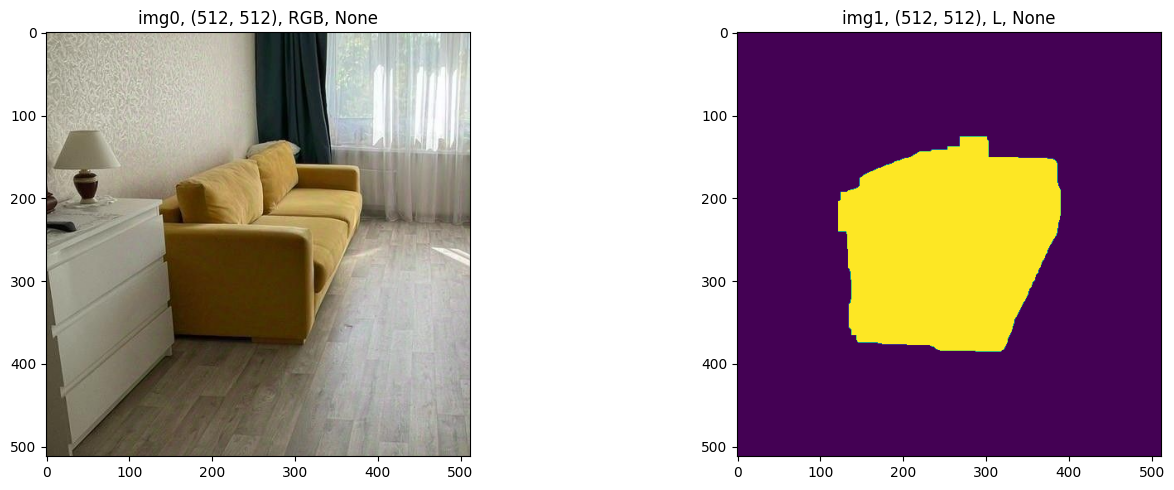

In [16]:
target_width, target_height = 512, 512
original_width, original_height = maskl.size

maskl_np = np.array(maskl)
img_np = np.array(img_pil)

# описываем границы маски прямоугольником
rows, cols = np.where(maskl_np == 255)
top, bottom = np.min(rows), np.max(rows)
left, right = np.min(cols), np.max(cols)

# пытаемся обрезать изображение до желаемого размера
new_left, new_right = expand_crop_side((left, right), original_width, target_width)
new_top, new_bottom = expand_crop_side((top, bottom), original_height, target_height)

# корректируем обрезку до размеров, кратным 8 (условие модели stable diffusion)
new_left, new_right = to_multiplicity_size(new_left, new_right, original_width, 8)
new_top, new_bottom = to_multiplicity_size(new_top, new_bottom, original_height, 8)

crop_coords = (new_left, new_top, new_right, new_bottom)
img_pil_cropped = img_pil.crop(crop_coords).copy()
maskl_cropped = maskl.crop(crop_coords).copy()

width, height = img_orig_pil_cropped.size

display_images([img_pil_cropped, maskl_cropped])

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

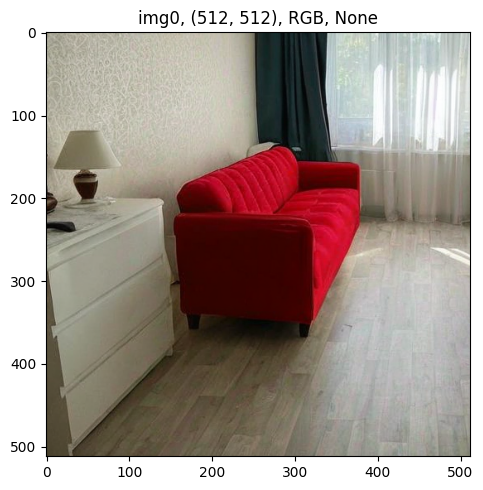

In [19]:
from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None
).to(DEVICE)

# inference
prompt = "red couch"
generator = torch.Generator(device=DEVICE).manual_seed(4)

img_generated_pil = pipe(
    prompt=prompt,
    image=img_pil_cropped,
    mask_image=maskl_cropped,
    guidance_scale=8.0,
    num_inference_steps=120, 
    strength=0.9,
    height=height,
    width=width,
    generator=generator,
)

img_generated_pil = img_generated_pil.images[0]
display_images([img_generated_pil])

In [26]:
repainted_image = img_generated_pil.copy()
init_image = img_pil_cropped.copy()
mask_image_arr = np.array(maskl_cropped.convert("L")).copy()

# Add a channel dimension to the end of the grayscale mask
mask_image_arr = mask_image_arr[:, :, None]

# Binarize the mask: 1s correspond to the pixels which are repainted
mask_image_arr = mask_image_arr.astype(np.float32) / 255.0
mask_image_arr[mask_image_arr < 0.5] = 0
mask_image_arr[mask_image_arr >= 0.5] = 1

# Take the masked pixels from the repainted image and the unmasked pixels from the initial image
unmasked_unchanged_image_arr = (1 - mask_image_arr) * init_image + mask_image_arr * repainted_image
unmasked_unchanged_image = Image.fromarray(unmasked_unchanged_image_arr.round().astype("uint8"))

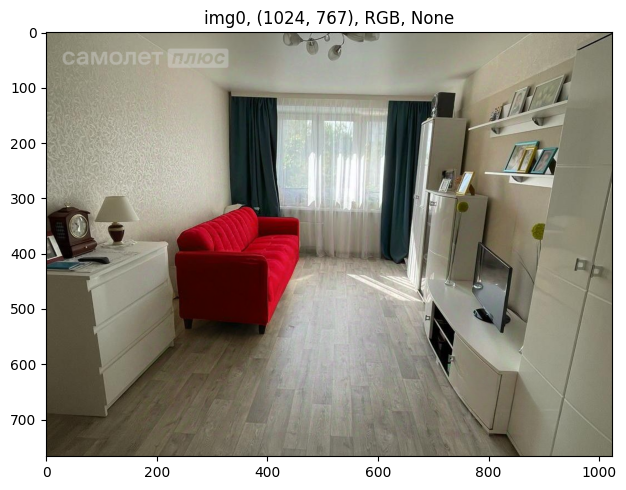

In [27]:
result = img_orig_pil.copy()
result.paste(unmasked_unchanged_image, crop_coords[:2])
display_images([result])

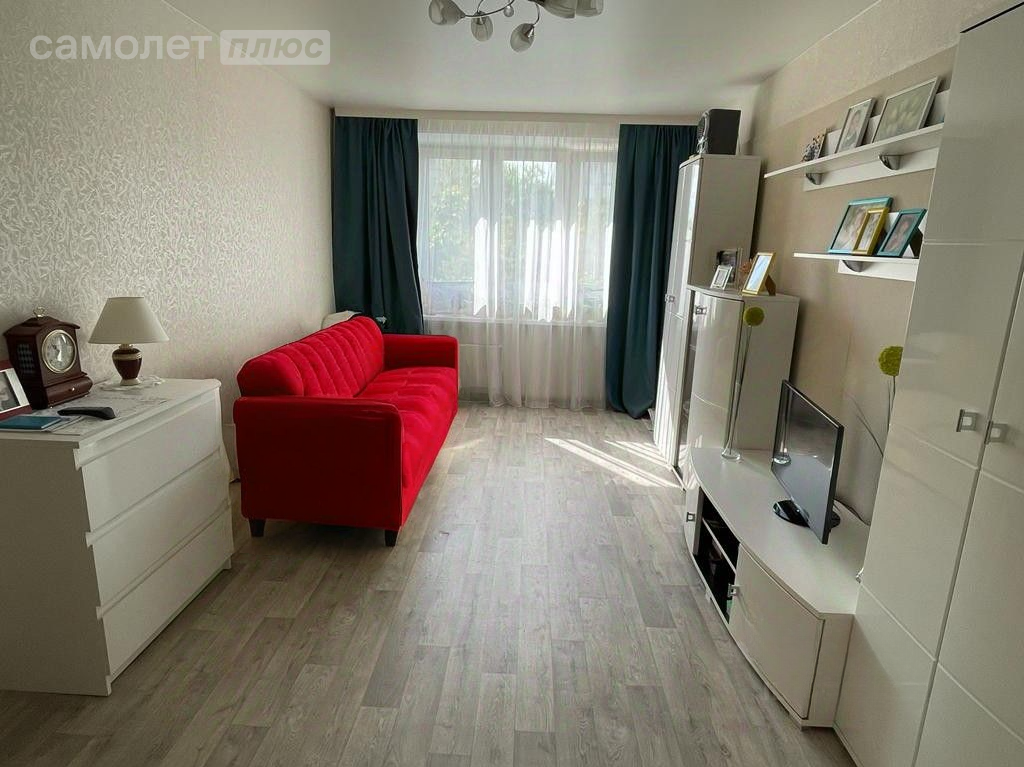

In [30]:
result

In [ ]:
# тут пример LAMA для удаления объекта, если он мелкий

In [ ]:
# тут пример сегментации всей картинки и оставкление только того, что в рамках bbox (большая часть)